# Do changes in season affect our health?

According to American Family Physician, about 4 to 6 percent of people may have winter depression. Another 10 to 20 percent may have mild seasonal affective disorder (SAD). Further, studies suggest SAD is four times more common in women than in men. SAD is also more common the farther north you go. For example, it's seven times more common in Washington state than in Florida.

Studies also suggest that your chance of getting SAD goes down as you get older.  Although, according to actuarial studies, the most deaths occur in January, gradually decreasing to August, when the rate of death begins increasing again through the holiday season.

## Does the data support the conclusion?


The Center for Disease Control (CDC) sponsors a program known as the Behavioral Risk Factor Surveillance System (BRFSS).  In this program, states, including all 50 states, the District of Columbia, Puerto Rico, Guam and the US Virgin Islands conduct a health assessment survey.  These telephone-based surveys are conducted monthly and can vary slightly by state or region.  American Samoa, the Federated States of Micronesia, and Palau participate in limited time spans.

The results of the surveys are available online through the CDC and are provided in annual sets.  There are hundreds of questions; however, most are optional.  The core portion is considered required with many sections of optional inquiry.  In addition, some questions are only presented based on a specific answer to a previous question.  The data for year 2015 is the most current available set on Kaggle and that is the data to be used to test the above stated conclusions.

The initial analysis will evaluate the respondents ranking of their general health, the number of days they felt physically ill and the number of days they felt stressed or otherwise mentally ill.  Each month, the respondents are asked to provide these answers in the context of the last 30 days.

### General Health Rankings

Respondents are asked to reflect on their general health over the past 30 days and rank their health in one of five categories.  The ranks are Excellent (1), Very Good (2), Good (3), Fair (4) and Poor (5).  This is a view of the responses by month during 2015.

In [1]:
# Set up the working environment by calling toolkits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import data file to a dataframe
health_2015 = pd.read_csv('2015.csv',low_memory=False)

In [3]:
# Import lookup values
months = pd.read_csv('months.csv',low_memory=False)
hlth_code = pd.read_csv('genhealth.csv',low_memory=False)
states = pd.read_csv('states.csv',low_memory=False)
msa = pd.read_csv('msa_lookup.csv',low_memory=False)
idates = pd.read_csv('idate.csv')

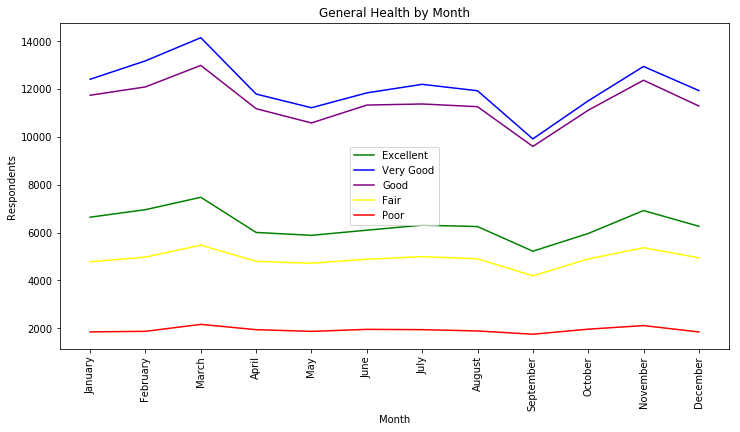

In [4]:
# View General Health Responses by Month, ignore missing and "don't know" responses
genhlth_mo = health_2015[health_2015['GENHLTH'] < 6].groupby(['IMONTH','GENHLTH'], as_index=False)['SEQNO'].count()
genhlth_mo = genhlth_mo.merge(months, on='IMONTH', how='left')
genhlth_mo = genhlth_mo.rename(columns={'SEQNO': 'RESPONSES', 'Description': 'MONAME'})

# Sub data by scale of general health
genhlth_mo1 = genhlth_mo[genhlth_mo['GENHLTH'] == 1]
genhlth_mo2 = genhlth_mo[genhlth_mo['GENHLTH'] == 2]
genhlth_mo3 = genhlth_mo[genhlth_mo['GENHLTH'] == 3]
genhlth_mo4 = genhlth_mo[genhlth_mo['GENHLTH'] == 4]
genhlth_mo5 = genhlth_mo[genhlth_mo['GENHLTH'] == 5]

# Visual 1
plt.figure(figsize=(12, 6))
plt.plot(genhlth_mo1['MONAME'], genhlth_mo1['RESPONSES'], color='green', label='Excellent')
plt.plot(genhlth_mo2['MONAME'], genhlth_mo2['RESPONSES'], color='blue', label='Very Good')
plt.plot(genhlth_mo3['MONAME'], genhlth_mo3['RESPONSES'], color='purple', label='Good')
plt.plot(genhlth_mo4['MONAME'], genhlth_mo4['RESPONSES'], color='yellow', label='Fair')
plt.plot(genhlth_mo5['MONAME'], genhlth_mo5['RESPONSES'], color='red', label='Poor')
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Respondents')
plt.title('General Health by Month')
plt.legend()
plt.show()

People tend to rank their health as very good and good much more often than Excellent.  For purposes of evaluating whether people are seasonally afflicted, ratings of Fair (4) or Poor (5) will be considered "feeling poorly".  Ratings of Excellent (1), Very good (2) and Good (3) will be considered feeling well.

The next view shows the general health responses by state.  In this case, it is necessary to compute the ratio of people responding in each rank to the total number of people responding in a given state.  This will allow the visual to illustrate differences in how people feel rather than highlighting population differences.

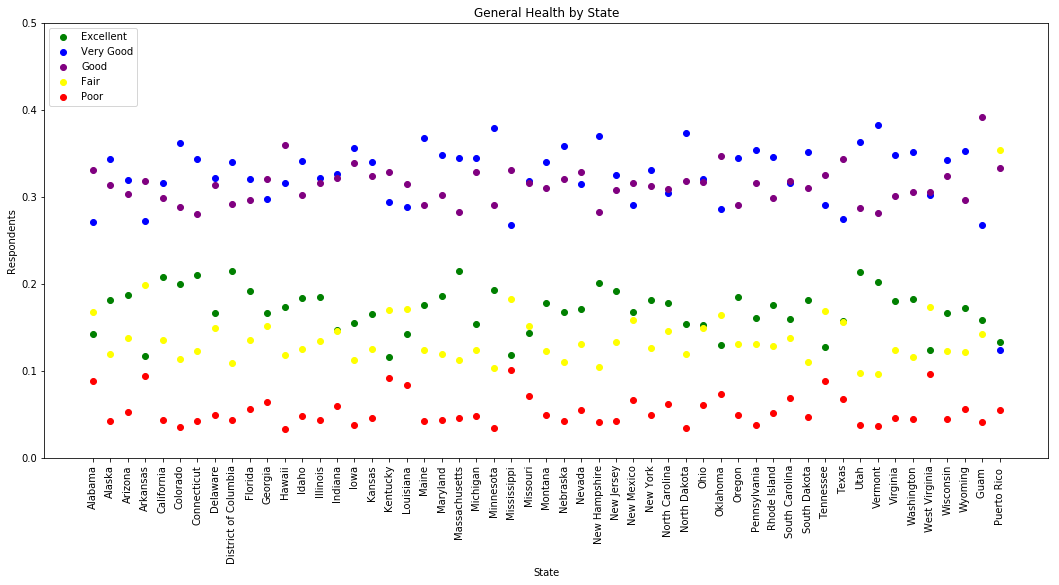

In [5]:
# Obtain total respondents by state
state_health_sum = health_2015[health_2015['GENHLTH'] < 6].groupby(['_STATE'], as_index=False)['GENHLTH'].count()

# Add state description to data of interest
state_sum_desc = state_health_sum.merge(states, on='_STATE', how='left')
state_sum_desc = state_sum_desc.rename(columns={'GENHLTH': 'TtlCount'})

# Group data by state and health ranking
state_health = health_2015.groupby(['_STATE','GENHLTH'], as_index=False)['SEQNO'].count()

# Merge the summary data with the details and calculate the percentages
state_health = state_health.merge(state_sum_desc, on='_STATE', how='left')
state_health['Ratio'] = state_health['SEQNO'] / state_health['TtlCount']

# Sub data by scale of general health
state_health1 = state_health[state_health['GENHLTH'] == 1]
state_health2 = state_health[state_health['GENHLTH'] == 2]
state_health3 = state_health[state_health['GENHLTH'] == 3]
state_health4 = state_health[state_health['GENHLTH'] == 4]
state_health5 = state_health[state_health['GENHLTH'] == 5]

# View General Health Responses using ratio of responses by state
plt.figure(figsize=(18, 8))
plt.scatter(state_health1['Description'], state_health1['Ratio'], color='green', label='Excellent')
plt.scatter(state_health2['Description'], state_health2['Ratio'], color='blue', label='Very Good')
plt.scatter(state_health3['Description'], state_health3['Ratio'], color='purple', label='Good')
plt.scatter(state_health4['Description'], state_health4['Ratio'], color='yellow', label='Fair')
plt.scatter(state_health5['Description'], state_health5['Ratio'], color='red', label='Poor')
plt.xticks(rotation=90)
plt.ylim(0,.5)
plt.xlabel('State')
plt.ylabel('Respondents')
plt.title('General Health by State')
plt.legend(loc='upper left')
plt.show()

The states will need to be assigned north, south and mid status to determine if there is a distinguishable difference between general health in these regions.  This view is presented below.

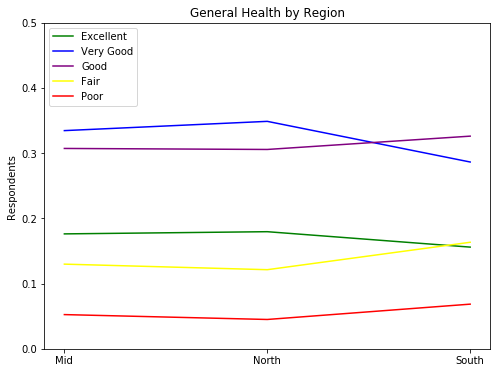

In [6]:
# Obtain total respondents by region
rgnl_health_sum = state_sum_desc.groupby(['Region'], as_index=False)['TtlCount'].sum()

# Group data by region and health ranking
rgnl_health = state_health.groupby(['Region','GENHLTH'], as_index=False)['SEQNO'].sum()

# Merge the summary data with the details and calculate the percentages
rgnl_health = rgnl_health.merge(rgnl_health_sum, on='Region', how='left')
rgnl_health['Ratio'] = rgnl_health['SEQNO'] / rgnl_health['TtlCount']

# Sub data by scale of general health
rgnl_health1 = rgnl_health[rgnl_health['GENHLTH'] == 1]
rgnl_health2 = rgnl_health[rgnl_health['GENHLTH'] == 2]
rgnl_health3 = rgnl_health[rgnl_health['GENHLTH'] == 3]
rgnl_health4 = rgnl_health[rgnl_health['GENHLTH'] == 4]
rgnl_health5 = rgnl_health[rgnl_health['GENHLTH'] == 5]

# View General Health Responses using ratio of responses by state
plt.figure(figsize=(8, 6))
plt.plot(rgnl_health1['Region'], rgnl_health1['Ratio'], color='green', label='Excellent')
plt.plot(rgnl_health2['Region'], rgnl_health2['Ratio'], color='blue', label='Very Good')
plt.plot(rgnl_health3['Region'], rgnl_health3['Ratio'], color='purple', label='Good')
plt.plot(rgnl_health4['Region'], rgnl_health4['Ratio'], color='yellow', label='Fair')
plt.plot(rgnl_health5['Region'], rgnl_health5['Ratio'], color='red', label='Poor')
plt.ylim(0,.5)
plt.ylabel('Respondents')
plt.title('General Health by Region')
plt.legend(loc='upper left')
plt.show()

This would indicate that respondents from the southern states have slightly less wellness than those from northern states.  This can be evaluated further by comparing the responses by season.  This view is included later.

Another evaluation factor is whether or not the respondent is a city dweller, a suburbian, or more rural.  The next view shows the general health rankings by metropolitan area (MSA).  The areas are defined by the US census bureau and are considered city-center, city (not city-center), suburbia, and none of the above which will be described as rural for purposes of this discussion.

<Figure size 2304x576 with 0 Axes>

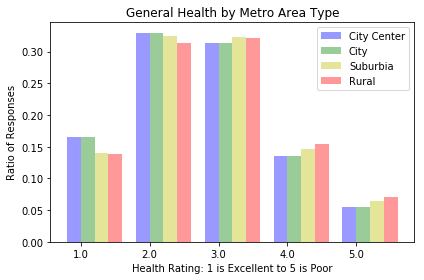

In [7]:
# View general health responses by city vs rural dwellers.  Again, we need the ratio of people responding in each
# scale category to the total number of people responding in a given metropolitan area.  This will allow the visual to
# illustrate differences in how people feel rather than highlighting population differences.
msa_health_sum = health_2015[health_2015['GENHLTH'] < 6].groupby(['MSCODE'], as_index=False)['GENHLTH'].count()

# Add msa description to data of interest
msa_sum_desc = msa_health_sum.merge(msa, on='MSCODE', how='left')
msa_sum_desc = msa_sum_desc.rename(columns={'GENHLTH': 'TtlCount'})

# Group data by metropolitan area and health ranking and merge with summary data to calculate the ratios
msa_health = health_2015[health_2015['GENHLTH'] < 6].groupby(['MSCODE','GENHLTH'], as_index=False)['SEQNO'].count()
msa_health = msa_health.merge(msa_sum_desc, on='MSCODE', how='left')
msa_health['Ratio'] = msa_health['SEQNO'] / msa_health['TtlCount']

# Sub data by scale of general health
msa_health1 = msa_health[msa_health['MSCODE'] == 1]
msa_health2 = msa_health[msa_health['MSCODE'] == 2]
msa_health3 = msa_health[msa_health['MSCODE'] == 3]
msa_health5 = msa_health[msa_health['MSCODE'] == 5]

# Let's see what it looks like based on city vs country dwellers
plt.figure(figsize=(32,8))
np.arange(5)

fig, ax = plt.subplots()

index = np.arange(5)
bar_width = 0.2

opacity = 0.4

rects1 = ax.bar(index, msa_health1['Ratio'], bar_width,
                alpha=opacity, color='b',
                label='City Center')

rects2 = ax.bar(index + bar_width, msa_health1['Ratio'], bar_width,
                alpha=opacity, color='g',
                label='City')

rects3 = ax.bar(index + (bar_width * 2), msa_health3['Ratio'], bar_width,
                alpha=opacity, color='y',
                label='Suburbia')

rects4 = ax.bar(index + (bar_width * 3), msa_health5['Ratio'], bar_width,
                alpha=opacity, color='r',
                label='Rural')

ax.set_xlabel('Health Rating: 1 is Excellent to 5 is Poor')
ax.set_ylabel('Ratio of Responses')
ax.set_title('General Health by Metro Area Type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((msa_health['GENHLTH']))
ax.legend()

fig.tight_layout()
plt.show()

The rankings appear fairly tightly clustered.  The Excellent response appears to be slightly more common among city dwellers and the lower health ratings seem to be slightly more common among non-city dwellers.

### Physical Health Responses

Respondents are asked "Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good?"  When answers are 0 days, the code "88" is recorded.  Otherwise, the number of days is recorded.  When respondents answer "I don't know", code "77" is recorded.  When respondents decline to answer, code "99" is recorded.  The code 88 is converted to zero so that total counts, averages and other numerical calculations can accurately reflect all responsdents.  Responses with codes 77 and 99 are eliminated from the evaluation. Follows is a distribution of the number of days reported.

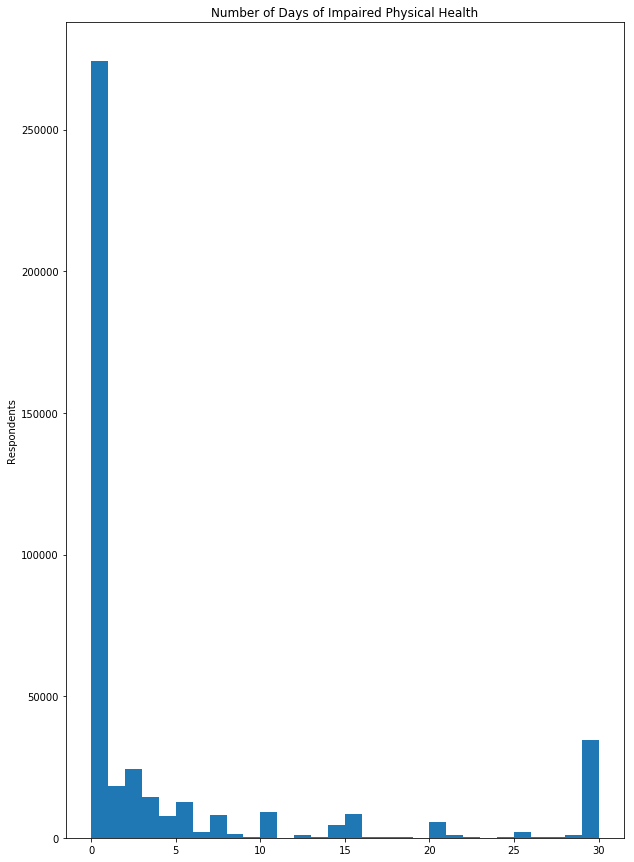

count    431713.000000
mean          4.299312
std           8.815969
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          30.000000
Name: PHYSHLTH, dtype: float64


In [8]:
# Update code 88 to 0 for the health responses so 0 days responses can be included in statistical calcs
health_2015['PHYSHLTH'] = np.where(health_2015['PHYSHLTH'] == 88, 0, health_2015['PHYSHLTH'])
# Ignore non-responsive answers
phys_hlth = health_2015[health_2015['PHYSHLTH'] < 32]

# View in Histogram
plt.figure(figsize=(10,15))
plt.hist(phys_hlth['PHYSHLTH'], bins=30)
plt.ylabel('Respondents')
plt.title('Number of Days of Impaired Physical Health')
plt.show()

# View descriptive statistics
print(phys_hlth['PHYSHLTH'].describe())

The average number of days (mean) that respondents reported being ill during the last 30 days is 4.3 days.  And, by far, the most reported number of days (mode) is zero.  The data does not conform well to a particular statistical distribution.  Next, the view shows the average number of physically ill days per month during 2015 compared with the total respondents by month.  

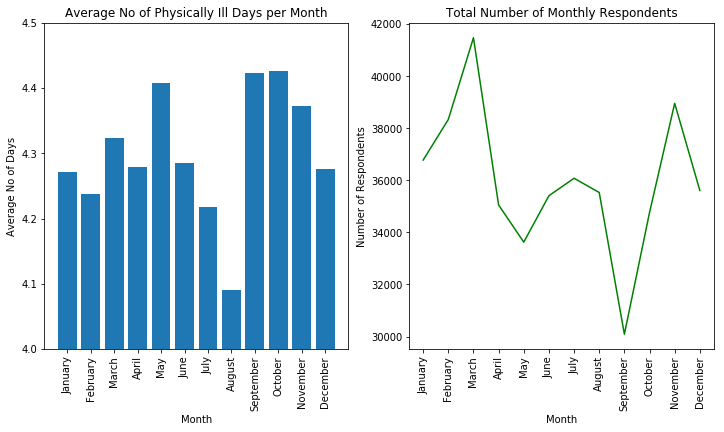

In [9]:
# Add the month to the data
phys_hlth = phys_hlth.merge(months, on='IMONTH', how='left')
# Calculate average days
pgrpd_hlth = phys_hlth.groupby(['IMONTH','Description'], as_index=False)['PHYSHLTH'].mean()
# Count total respondents by month
pgrpd_hlth_cnt = phys_hlth.groupby(['IMONTH','Description'], as_index=False)['PHYSHLTH'].count()
# view the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(pgrpd_hlth['Description'], pgrpd_hlth['PHYSHLTH'])
plt.xticks(rotation=90)
plt.ylim(4,4.5)
plt.xlabel('Month')
plt.ylabel('Average No of Days')
plt.title('Average No of Physically Ill Days per Month')

plt.subplot(1, 2, 2)
plt.plot(pgrpd_hlth_cnt['Description'], pgrpd_hlth_cnt['PHYSHLTH'], color='green')
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Number of Respondents')
plt.title('Total Number of Monthly Respondents')
plt.show()

September and October have the highest number of reported days of feeling ill in the past 30 days. September has the lowest number of respondents and March has the highest.  It would be prudent to examine the number of responses further to determine if there is sufficient bias to render any conclusions regarding monthly or seasonal data invalid. 

### Mental Health Responses

Respondents are also asked about their mental health, to include stress, depression, and problems with emotions.  The responses are recorded in the same way as the responses for physical health. Again, the code 88 (no days) is converted to zero so that computations may be performed.  And, responses with codes 77 and 99 are eliminated from the evaluation. This is a view of the average number of mentally ill days per month during 2015.

In [10]:
# Update code 88 to 0 for the health responses so 0 days responses can be included in statistical calcs
health_2015['MENTHLTH'] = np.where(health_2015['MENTHLTH'] == 88, 0, health_2015['MENTHLTH'])

# Filter on mental health responses
ment_hlth = health_2015[health_2015['MENTHLTH'] < 32]
mgrpd_hlth = ment_hlth.groupby(['IMONTH'], as_index=False)['MENTHLTH'].mean()
mgrpd_hlth = mgrpd_hlth.merge(months, on='IMONTH', how='left')

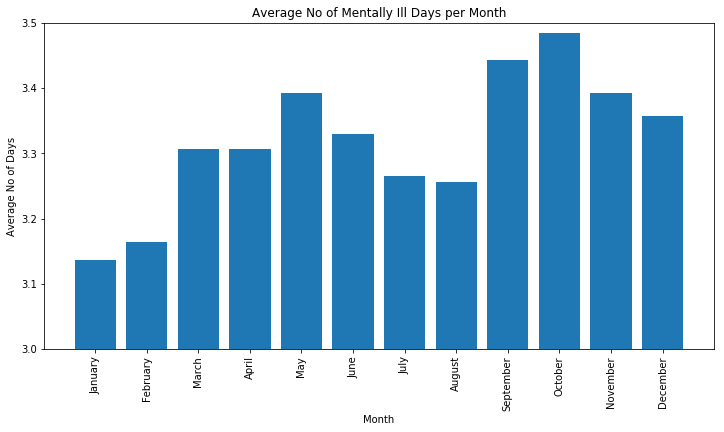

In [11]:
plt.figure(figsize=(12, 6))
plt.bar(mgrpd_hlth['Description'], mgrpd_hlth['MENTHLTH'])
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylim(3,3.5)
plt.ylabel('Average No of Days')
plt.title('Average No of Mentally Ill Days per Month')
plt.show()

### Poor Health Responses

The last data item to examine for this discussion is the response to the question "During the past 30 days, for about how many days did poor physical or mental health keep you from doing your usual activities, such as self-care, work, or recreation?"  The responses are recorded (and evaluated) in the same manner as those for physical and mental health.  This is a view of the average number of days per month respondents reported that ailments prevented them from performing one or more of their usual activities.

In [12]:
# Update code 88 to 0 for the health responses so 0 days responses can be included in statistical calcs
health_2015['POORHLTH'] = np.where(health_2015['POORHLTH'] == 88, 0, health_2015['POORHLTH'])

# Filter on poor health responses
poor_hlth = health_2015[health_2015['POORHLTH'] < 32]
xgrpd_hlth = poor_hlth.groupby(['IMONTH'], as_index=False)['POORHLTH'].mean()
xgrpd_hlth = xgrpd_hlth.merge(months, on='IMONTH', how='left')

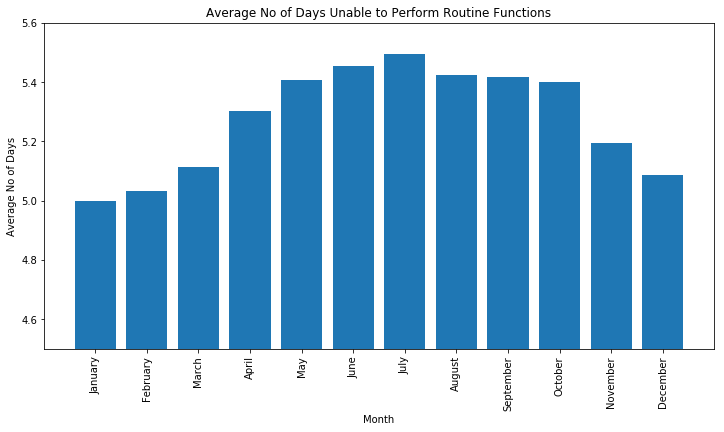

In [13]:
plt.figure(figsize=(12, 6))
plt.bar(xgrpd_hlth['Description'], xgrpd_hlth['POORHLTH'])
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylim(4.5,5.6)
plt.ylabel('Average No of Days')
plt.title('Average No of Days Unable to Perform Routine Functions')
plt.show()

## Additional Analysis

### Does winter depression affect 4 to 6 percent of the people?

When one examines the base data on the surface, this does not appear to be supported by this survey.  For example, October has the highest number of respondents reporting poor physical health with September following closely.  For mental health, October has the highest average number of reported days of feeling bad.  And, the average number of days people reported being unable to perform normal functions is highest in July, with June, August and September in close competition.

To further evaluate whether the 2015 CDC data supports the conclusion that winter depression affects 4 to 6 percent of the people, the data will need to identified seasonally.  To accomplish this, winter will be defined as responses given from January 15 to April 15 which should actually cover the time period of December 16 to March 16. 

For purposes of evaluating general health, ratings of Fair (4) or Poor (5) will be considered as "feeling poorly".  Ratings of Excellent (1), Very good (2) and Good (3) will be considered as "feeling well".

For purposes of evaluating mental health issues that would indicate winter depression, the proportion of respondents reporting more than 6 days of mental illness during the winter time frame will be compared to the proportion of respondents reporting more than 6 days during the non-winter timeframe.  Respondents with 6 or less days will be considered as "feeling well".  The poor health responses can be evaluated in this same manner.

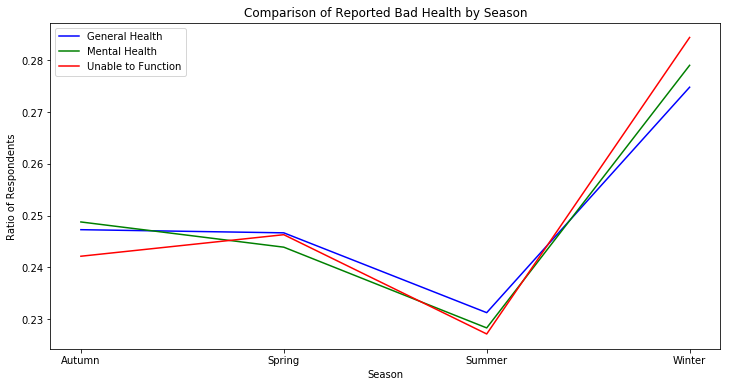

In [14]:
# Add season to data
season_health = health_2015.merge(idates, on='IDATE', how='left')

# Filter responses for General Health for feeling poorly
season_health['BadGen'] = season_health['GENHLTH'].isin([4,5])

# Counts of responses for General Health by Season
season_gen_hlth = season_health[season_health['BadGen'] == True]
season_sum = season_gen_hlth.groupby(['Season'], as_index=False)['SEQNO'].count()
season_sum['TtlCount'] = season_health[season_health['BadGen'] == True]['SEQNO'].count()

# Add ratio of bad health to total by season
season_sum['Ratio'] = season_sum['SEQNO'] / season_sum['TtlCount']

# Filter responses for Mental Health with more than 6 reported days
season_health['BadMent'] = (season_health['MENTHLTH'] > 6) & (season_health['MENTHLTH'] < 32)

# Counts of responses for "bad" Mental Health by Season
season_ment_hlth = season_health[season_health['BadMent'] == True]
season_msum = season_ment_hlth.groupby(['Season'], as_index=False)['SEQNO'].count()

# Total of respondents with more than 6 days for all seasons
season_msum['TtlCount'] = season_health[season_health['BadMent'] == True]['SEQNO'].count()

# Add ratio of bad health to total by season
season_msum['Ratio'] = season_msum['SEQNO'] / season_msum['TtlCount']

# Filter responses for Poor Health with more than 6 reported days
season_health['Downtime'] = (season_health['POORHLTH'] > 6) & (season_health['POORHLTH'] < 32)

# Counts of responses for non-functioning Health by Season
season_poor_hlth = season_health[season_health['Downtime'] == True]
season_psum = season_poor_hlth.groupby(['Season'], as_index=False)['SEQNO'].count()

# Total of respondents with more than 6 days for all seasons
season_psum['TtlCount'] = season_health[season_health['Downtime'] == True]['SEQNO'].count()

# Add ratio of bad health to total by season
season_psum['Ratio'] = season_psum['SEQNO'] / season_psum['TtlCount']

# Use visual to compare results
plt.figure(figsize=(12, 6))
plt.plot(season_sum['Season'],season_sum['Ratio'], color='blue', label='General Health')
plt.plot(season_msum['Season'],season_msum['Ratio'], color='green', label='Mental Health')
plt.plot(season_psum['Season'],season_psum['Ratio'], color='red', label='Unable to Function')
plt.xlabel('Season')
plt.ylabel('Ratio of Respondents')
plt.title('Comparison of Reported Bad Health by Season')
plt.legend(loc='upper left')
plt.show()

When analyzing responses based on comparing reported poor health throughout the year, winter appears to have a greater amount of poor health.  

In [15]:
spring_ratio = season_msum['Ratio'][season_msum['Season'] == 'Spring']
summer_ratio = season_msum['Ratio'][season_msum['Season'] == 'Summer']
autumn_ratio = season_msum['Ratio'][season_msum['Season'] == 'Autumn']
winter_ratio = season_msum['Ratio'][season_msum['Season'] == 'Winter']
total_ratio = season_msum['Ratio'].sum()
count_ratio = season_msum['Ratio'].count()
winter_to_all = winter_ratio - ((total_ratio - winter_ratio) / (count_ratio - 1))
print('How much greater was winter depression to other seasons?  ' + str(winter_to_all))

How much greater was winter depression to other seasons?  3    0.038662
Name: Ratio, dtype: float64


In [16]:
season_msum = season_msum.rename(columns={'SEQNO': 'M_Cnt', 'TtlCount' : 'M_Ttl', 'Ratio' : 'M_Ratio'})
season_psum = season_psum.rename(columns={'SEQNO': 'P_Cnt', 'TtlCount' : 'P_Ttl', 'Ratio' : 'P_Ratio'})
season_sum_all = season_sum.merge(season_msum, on='Season', how='left')
season_sum_all = season_sum_all.merge(season_psum, on='Season', how='left')
season_sum_all

,Season,SEQNO,TtlCount,Ratio,M_Cnt,M_Ttl,M_Ratio,P_Cnt,P_Ttl,P_Ratio
0,Autumn,20311,82137,0.247282,15696,63094,0.248772,12414,51264,0.242158
1,Spring,20261,82137,0.246673,15389,63094,0.243906,12627,51264,0.246313
2,Summer,18996,82137,0.231272,14406,63094,0.228326,11645,51264,0.227157
3,Winter,22569,82137,0.274773,17603,63094,0.278996,14578,51264,0.284371


In fact, in terms of mental health, the survey respondents were nearly 4% more likely to feel bad in winter than in other seasons.  The respondents were a bit more than 4.5% likely to feel unable to function normally in winter than in other seasons.  And, they were 3.3% more likely to feel generally unwell in winter as compared to other seasons.

### Does stress impact health?

There are two survey questions that query respondents as to their perceived stress levels.  They are: "How often in the past 12 months would you say you were worried or stressed about having enough money to pay your rent/mortgage?" and "How often in the past 12 months would you say you were worried or stressed about having enough money to buy nutritious meals?"
The responses of "Usually", "Often" and "Sometimes" will be defined as stressed.

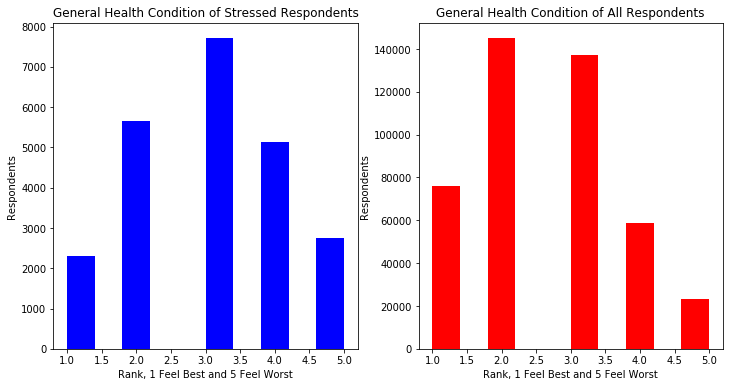

In [17]:
# Does feeling stressed appear to have a direct impact on general health?

# Mark respondents with answers of Usually, Often and Sometimes as being "stressed"
health_2015['STRSS'] = np.where((health_2015['SCNTMEL1'] < 4) | (health_2015['SCNTMNY1'] < 4),True,False)

# Isolate responses with stress
sub_health = health_2015[health_2015['STRSS'] == True]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(sub_health['GENHLTH'][sub_health['GENHLTH'] < 6], bins=10, color='blue')
plt.xlabel('Rank, 1 Feel Best and 5 Feel Worst')
plt.ylabel('Respondents')
plt.title('General Health Condition of Stressed Respondents')

plt.subplot(1, 2, 2)
plt.hist(health_2015['GENHLTH'][health_2015['GENHLTH'] < 6], bins=10, color='red')
plt.xlabel('Rank, 1 Feel Best and 5 Feel Worst')
plt.ylabel('Respondents')
plt.title('General Health Condition of All Respondents')

plt.show()

It certainly appears that stress does contribute to poor health.  The respondents reporting stress also report feeling poorly in a much higher proportion than those not reporting stress. 

### Is winter depression more common the farther north you go?

To evaluate whether winter depression is more common in northern states, states were assigned to categories of north, south and mid.  Then, the mental health responses were compared across these categories.  Again, winter will be defined as responses given from January 15 to April 15 which should actually cover the time period of December 16 to March 16. And, more than 6 days of reported mental illness will be considered poor health.

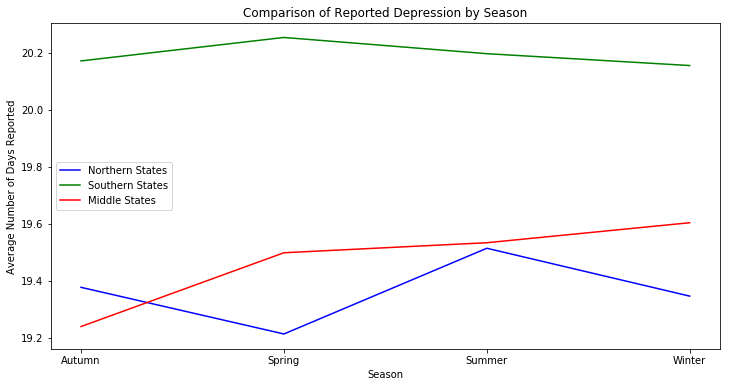

In [18]:
# Add region to seasonal data
rgnl_health_season = season_health.merge(states, on='_STATE', how='left')

# Group data by region and season
rs_health = rgnl_health_season[rgnl_health_season['BadMent'] == True].groupby(['Region','Season'], as_index=False)['MENTHLTH'].mean()
mid_rs_health = rs_health[rs_health['Region'] == "Mid"]
south_rs_health = rs_health[rs_health['Region'] == "South"]
north_rs_health = rs_health[rs_health['Region'] == "North"]

# Use visual to compare results
plt.figure(figsize=(12, 6))
plt.plot(north_rs_health['Season'],north_rs_health['MENTHLTH'], color='blue', label='Northern States')
plt.plot(south_rs_health['Season'],south_rs_health['MENTHLTH'], color='green', label='Southern States')
plt.plot(mid_rs_health['Season'],mid_rs_health['MENTHLTH'], color='red', label='Middle States')
plt.xlabel('Season')
plt.ylabel('Average Number of Days Reported')
plt.title('Comparison of Reported Depression by Season')
plt.legend(loc='center left')
plt.show()

This indicates that southern states have a much higher incidence of depression.  And, that it is throughout the year, not just in winter months.  Below is a comparison that is a includes all reported days of health (includes days reported of zero through six).

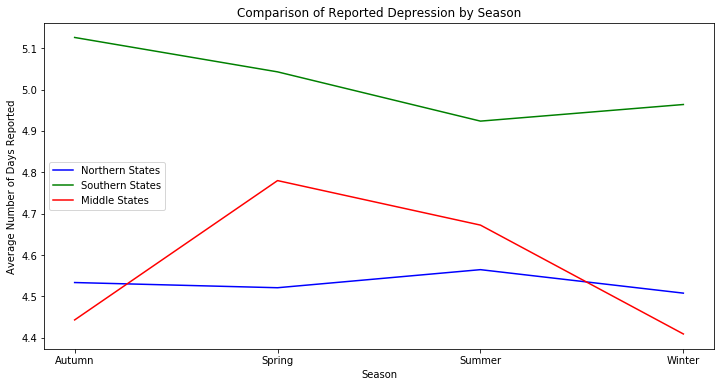

In [19]:
rs2_health = rgnl_health_season.groupby(['Region','Season'], as_index=False)['MENTHLTH'].mean()
mid2_rs_health = rs2_health[rs2_health['Region'] == "Mid"]
south2_rs_health = rs2_health[rs2_health['Region'] == "South"]
north2_rs_health = rs2_health[rs2_health['Region'] == "North"]

# Use visual to compare results
plt.figure(figsize=(12, 6))
plt.plot(north2_rs_health['Season'],north2_rs_health['MENTHLTH'], color='blue', label='Northern States')
plt.plot(south2_rs_health['Season'],south2_rs_health['MENTHLTH'], color='green', label='Southern States')
plt.plot(mid2_rs_health['Season'],mid2_rs_health['MENTHLTH'], color='red', label='Middle States')
plt.xlabel('Season')
plt.ylabel('Average Number of Days Reported')
plt.title('Comparison of Reported Depression by Season')
plt.legend(loc='center left')
plt.show()

The results are very similar.  Although, the middle states have a lower average of depression days during winter than the northern states.  In general, it does not appear to support the statement that SAD is more common in northern states.  Additional research in the area of defining depression and additional regional categories that use lattitudes might provide different insights.

# Additional Research

In addition to adding more geographical delineation to the analysis of whether SAD is more common in northern states, it would be interesting to evaluate whether the combination of living in a northern state and a city differ significantly from living in a Northern state and not living in a city.  Adding the poor health and general health responses into the evaluation could also provide additional insights.

One of the early analyses revealed that September, October and May had the highest number of respondents reporting that they did not feel generally well.  This corresponds to times when seasonal allergies are peaking.  Is there any information available to remove responses related to allergies so that other health issues can be evaluated without allergies skewing the results?  The survey does not include any allergy-specific questions, so it might not be possible to do this analysis with this data set.  It will be necessary to do some additional research to determine whether there is a data set that would allow correlation to allergies.

As identified when examining physical health responses, it would be prudent to compare each month to the center.  Does having more people reporting feeling poorly in particular months have any direct relationship to the number of people responding?  In other words, the higher the number of responses, the lower/higher the number of ill days? 

These initial analyses of this data raise many more questions.  Further research and analysis of this data could also include evaluating whether there is a correlation between age and responses. If all these same analyses were redone with the data stratified by age groups, would the conclusions change?  